### Part 1: Data Selection, Visualization, and Introduction

In [ ]:
! pip install pandas
# ! pip install numpy
# ! pip install matplotlib
# ! pip install seaborn

In [ ]:
! pip install prophet

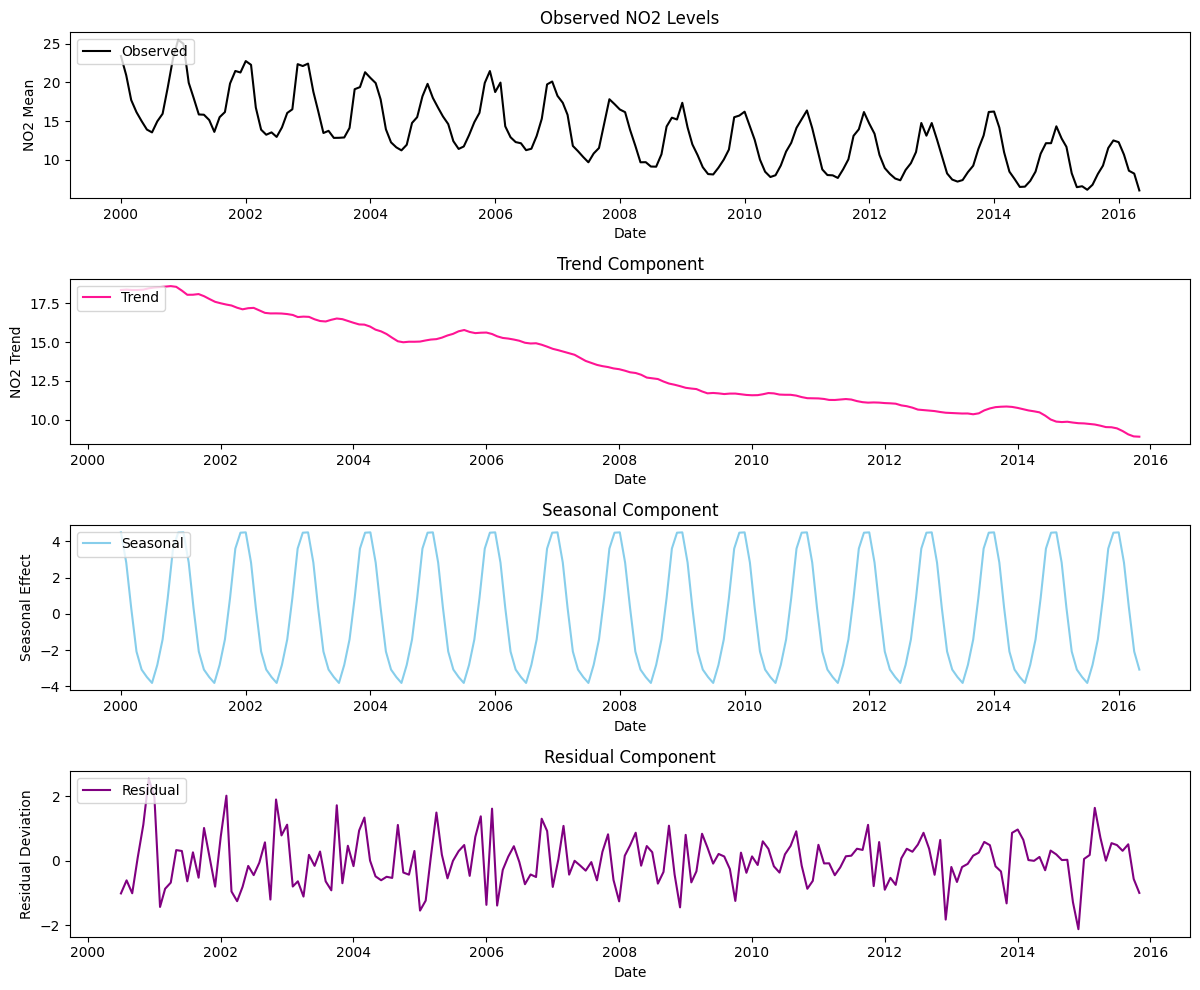

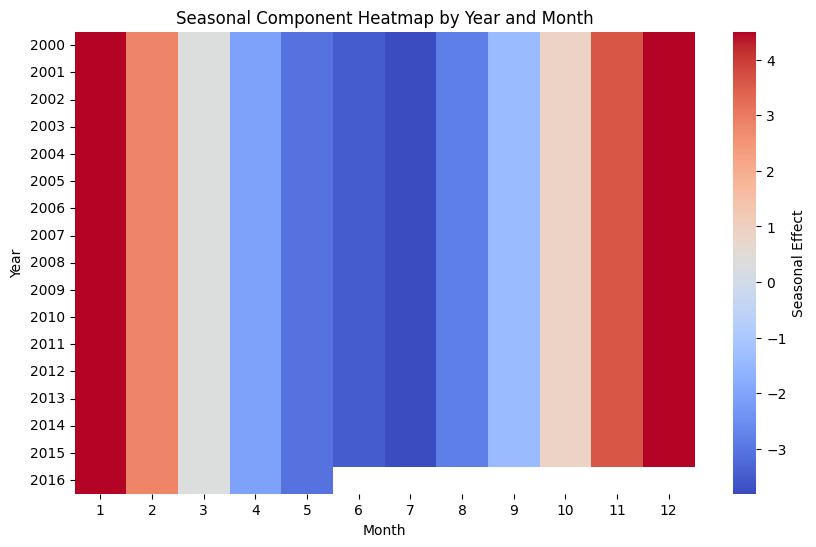

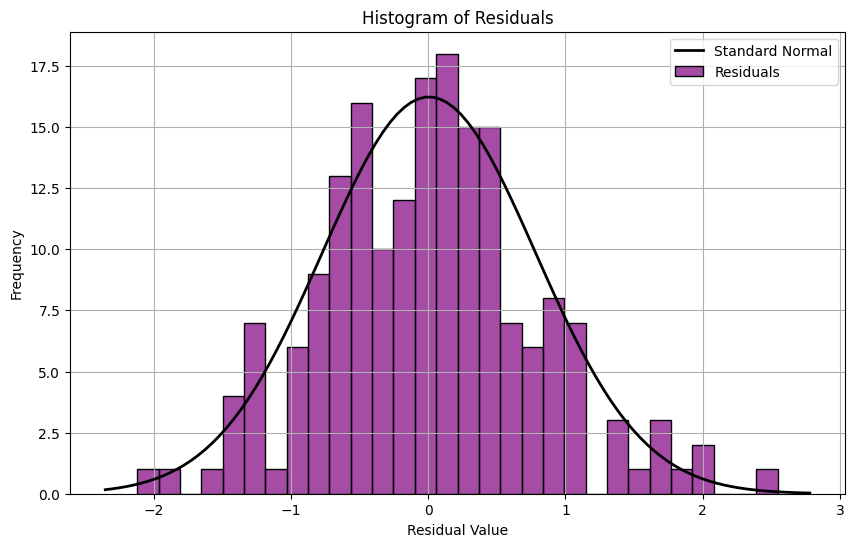

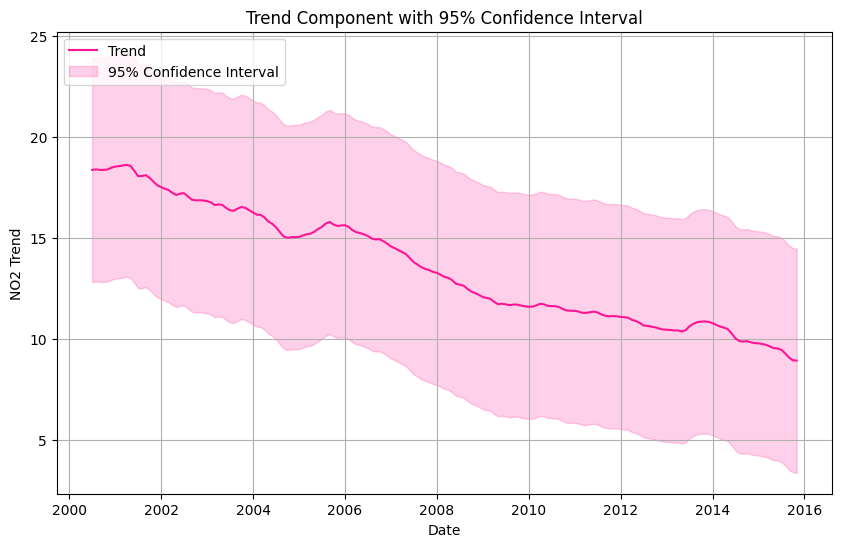

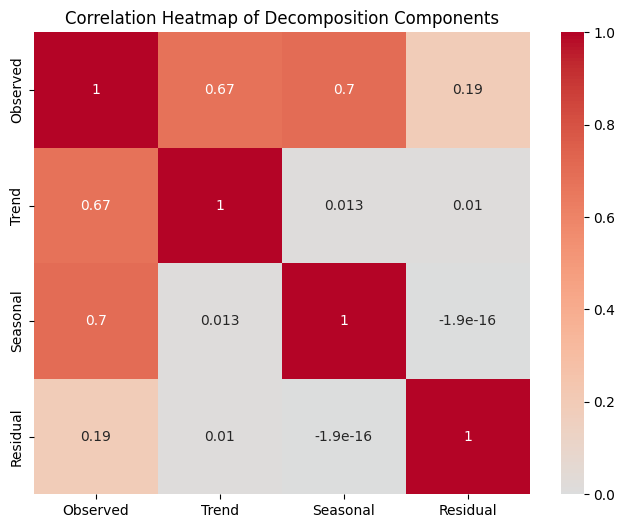

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import scipy.stats as stats

# Load the dataset
file_path = "uspollution_pollution_us_2000_2016.csv"
df = pd.read_csv(file_path)

# Convert 'Date Local' to datetime format
df["Date Local"] = pd.to_datetime(df["Date Local"])

# Aggregate by month (compute mean NO2 levels)
df["Year-Month"] = df["Date Local"].dt.to_period("M")  # Group by year-month
df_grouped = df.groupby("Year-Month")["NO2 Mean"].mean()

# Drop missing values
df_grouped = df_grouped.dropna()

# Convert period index to datetime for decomposition
df_grouped.index = df_grouped.index.to_timestamp()

# Perform seasonal decomposition with monthly period
decomposition = seasonal_decompose(df_grouped, model="additive", period=12)  # Monthly seasonality

# Plot decomposition
plt.figure(figsize=(12, 10))

# Observed Component
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label="Observed", color="black")
plt.legend(loc="upper left")
plt.title("Observed NO2 Levels")
plt.xlabel("Date")
plt.ylabel("NO2 Mean")

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color="deeppink")
plt.legend(loc="upper left")
plt.title("Trend Component")
plt.xlabel("Date")
plt.ylabel("NO2 Trend")

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonal", color="skyblue")
plt.legend(loc="upper left")
plt.title("Seasonal Component")
plt.xlabel("Date")
plt.ylabel("Seasonal Effect")

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residual", color="purple")
plt.legend(loc="upper left")
plt.title("Residual Component")
plt.xlabel("Date")
plt.ylabel("Residual Deviation")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Creative Visualizations

# 1. Alternative Seasonal Component Heatmap (without reshaping)
# We'll create a seasonal component over time by extracting the seasonal effects per year
seasonal_df = pd.DataFrame({
    'Date': decomposition.seasonal.index,
    'Seasonal Effect': decomposition.seasonal.values
})

seasonal_df['Month'] = seasonal_df['Date'].dt.month
seasonal_df['Year'] = seasonal_df['Date'].dt.year

# Pivot the seasonal effects by year and month
seasonal_pivot = seasonal_df.pivot(index='Year', columns='Month', values='Seasonal Effect')

plt.figure(figsize=(10, 6))
sns.heatmap(seasonal_pivot, cmap="coolwarm", annot=False, cbar_kws={'label': 'Seasonal Effect'})
plt.title("Seasonal Component Heatmap by Year and Month")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

# 2. Histogram of Residuals to visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(decomposition.resid.dropna(), bins=30, kde=False, color='purple', alpha=0.7, label='Residuals')
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")

# Add a line for the standard normal distribution
mu, std = np.mean(decomposition.resid.dropna()), np.std(decomposition.resid.dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p * len(decomposition.resid.dropna()) * (xmax - xmin) / 30, 'k', linewidth=2, label='Standard Normal')

plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# 3. Trend with Confidence Interval (using 95% confidence bounds)
plt.figure(figsize=(10, 6))
plt.plot(decomposition.trend, label="Trend", color="deeppink")
plt.fill_between(decomposition.trend.index, 
                 decomposition.trend - 1.96*decomposition.trend.std(), 
                 decomposition.trend + 1.96*decomposition.trend.std(), 
                 color='deeppink', alpha=0.2, label="95% Confidence Interval")
plt.title("Trend Component with 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("NO2 Trend")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# 4. Correlation Heatmap of Observed, Trend, Seasonal, and Residual Components
data = pd.DataFrame({
    'Observed': decomposition.observed,
    'Trend': decomposition.trend,
    'Seasonal': decomposition.seasonal,
    'Residual': decomposition.resid
})

corr_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Decomposition Components")
plt.show()

### Part 2: Model Fitting

In [ ]:
!pip install hmmlearn

In [ ]:
!pip install ruptures

16:09:21 - cmdstanpy - INFO - Chain [1] start processing
16:09:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\LENOVO\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
c:\Users\LENOVO\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA - MSE: 0.70, MAE: 0.68, MAPE: 9.00%
Prophet - MSE: 0.81, MAE: 0.81, MAPE: 9.68%
Fourier Regression - MSE: 0.92, MAE: 0.80, MAPE: 10.45%


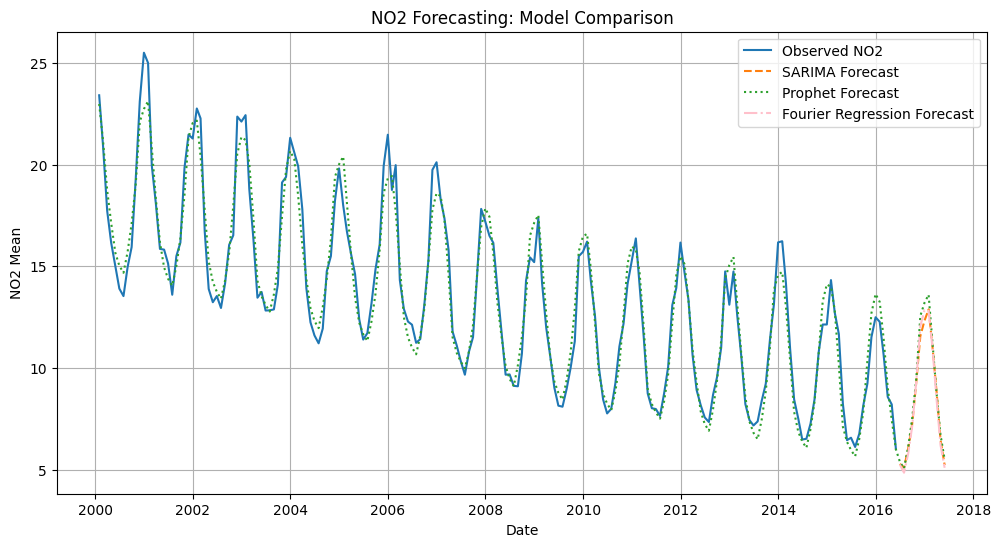

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load dataset
df = pd.read_csv("uspollution_pollution_us_2000_2016.csv")
df["Date Local"] = pd.to_datetime(df["Date Local"])
df.set_index("Date Local", inplace=True)

# Aggregate NO2 mean monthly
df_monthly = df.resample("ME")[["NO2 Mean"]].mean().dropna()

### Part 2: Model Fitting - Rationale, Forecasting, and Evaluation
# 1. SARIMA Model
# Rationale: SARIMA is suitable for capturing seasonality and non-stationarity, common in environmental data like NO2 levels.
# Parameter Selection: (p,d,q) = (1,1,1) for ARIMA components, (P,D,Q,12) = (1,1,1,12) for seasonal components.
# Forecasting: Predicts the next 12 months of NO2 levels.
# Reason: Captures seasonality and non-stationarity in time series
sarima_model = SARIMAX(df_monthly, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
forecast_sarima = sarima_model.get_forecast(steps=12).predicted_mean

# 2. Prophet Model
# Rationale: Prophet is effective for handling missing data, outliers, and strong seasonal components.
# Parameter Selection: Default parameters are used, suitable for monthly data with yearly seasonality.
# Forecasting: Generates a 12-month forecast of NO2 levels.
# Reason: Handles seasonality, trends, and missing data effectively
df_prophet = df_monthly.reset_index().rename(columns={"Date Local": "ds", "NO2 Mean": "y"})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=12, freq="M")
forecast_prophet = prophet_model.predict(future)

# 3. Regression with Fourier Terms
# Rationale: Fourier terms effectively capture complex seasonality, making them suitable for cyclical environmental data.
# Parameter Selection: Seasonal period set to 12 (monthly data), using two Fourier terms.
# Forecasting: Generates a 12-month forecast of NO2 levels using Fourier terms as regressors.
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=df_monthly.index, constant=True, order=1, seasonal=True, period=12)
x_reg = dp.in_sample()
reg_model = SARIMAX(df_monthly["NO2 Mean"], exog=x_reg, order=(1,1,1)).fit()
x_forecast = dp.out_of_sample(steps=12)
forecast_reg = reg_model.get_forecast(steps=12, exog=x_forecast).predicted_mean

### Model Evaluation - Comparing Forecast Accuracy
# Evaluation Metrics: MSE (Mean Squared Error), MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error)
# The forecasts from each model are compared against the last 12 months of actual NO2 data.
from sklearn.metrics import mean_absolute_percentage_error as mape
models = {
    "SARIMA": forecast_sarima,
    "Prophet": forecast_prophet["yhat"].iloc[-12:],
    "Fourier Regression": forecast_reg
}

for name, forecast in models.items():
    mse = mean_squared_error(df_monthly.iloc[-12:]["NO2 Mean"], forecast)
    mae = mean_absolute_error(df_monthly.iloc[-12:]["NO2 Mean"], forecast)
    mape_per = mape(df_monthly.iloc[-12:]["NO2 Mean"], forecast)*100
    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape_per:.2f}%")

### Visual Comparison
plt.figure(figsize=(12,6))
plt.plot(df_monthly, label="Observed NO2")
plt.plot(forecast_sarima, label="SARIMA Forecast", linestyle="dashed")
plt.plot(forecast_prophet["ds"], forecast_prophet["yhat"], label="Prophet Forecast", linestyle="dotted")
plt.plot(forecast_reg.index, forecast_reg, label="Fourier Regression Forecast", linestyle="dashdot", color='pink')
plt.legend()
plt.title("NO2 Forecasting: Model Comparison")
plt.xlabel("Date")
plt.ylabel("NO2 Mean")
plt.grid(True)
plt.show()

### Part 3: Incorporating an Exogenous Variable (O3 levels)

Exogenous Model Forecast - MSE: 0.66, MAE: 0.66, MAPE: 8.71%


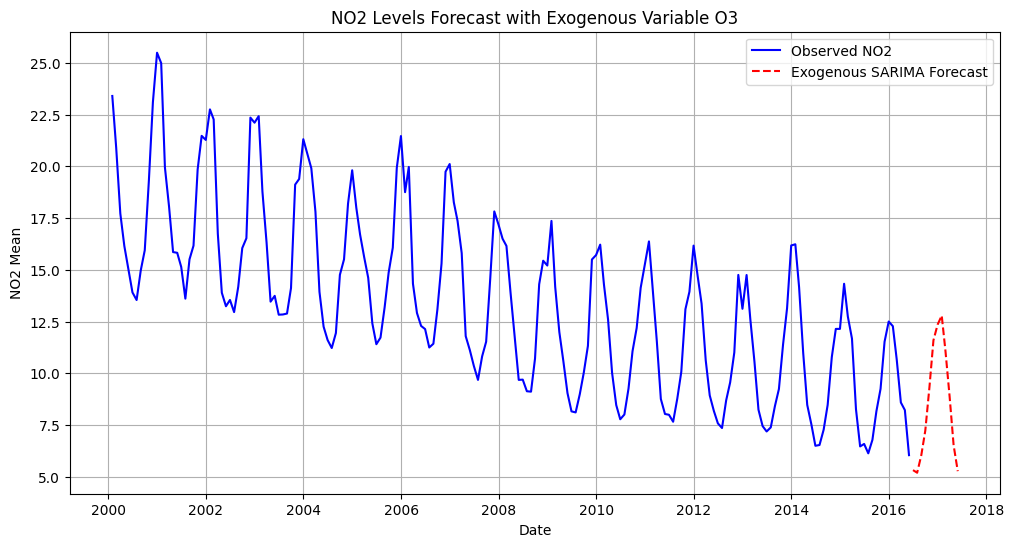

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Load dataset
df = pd.read_csv("uspollution_pollution_us_2000_2016.csv")
df["Date Local"] = pd.to_datetime(df["Date Local"])
df.set_index("Date Local", inplace=True)

# Aggregate monthly means
df_monthly = df.resample("ME")[["NO2 Mean", "O3 Mean"]].mean().dropna()

# Model fitting with exogenous variable O3
exog_model = SARIMAX(df_monthly["NO2 Mean"], exog=df_monthly["O3 Mean"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
forecast_exog = exog_model.get_forecast(steps=12, exog=df_monthly["O3 Mean"].iloc[-12:]).predicted_mean

# Evaluation
mse_exog = mean_squared_error(df_monthly.iloc[-12:]["NO2 Mean"], forecast_exog)
mae_exog = mean_absolute_error(df_monthly.iloc[-12:]["NO2 Mean"], forecast_exog)
mape_exog = mean_absolute_percentage_error(df_monthly.iloc[-12:]["NO2 Mean"], forecast_exog)

print("Exogenous Model Forecast - MSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}%".format(mse_exog, mae_exog, mape_exog * 100))

# Visual Comparison
plt.figure(figsize=(12, 6))
plt.plot(df_monthly["NO2 Mean"], label="Observed NO2", color="blue")
plt.plot(forecast_exog.index, forecast_exog, label="Exogenous SARIMA Forecast", linestyle="--", color="red")
plt.title("NO2 Levels Forecast with Exogenous Variable O3")
plt.xlabel("Date")
plt.ylabel("NO2 Mean")
plt.legend()
plt.grid(True)
plt.show()

### Part 4: Change-Point Detection

Pettitt's test between segments 0 and 1 - p-value: 0.0002
Pettitt's test between segments 1 and 2 - p-value: 0.0000
Pettitt's test between segments 2 and 3 - p-value: 0.0000


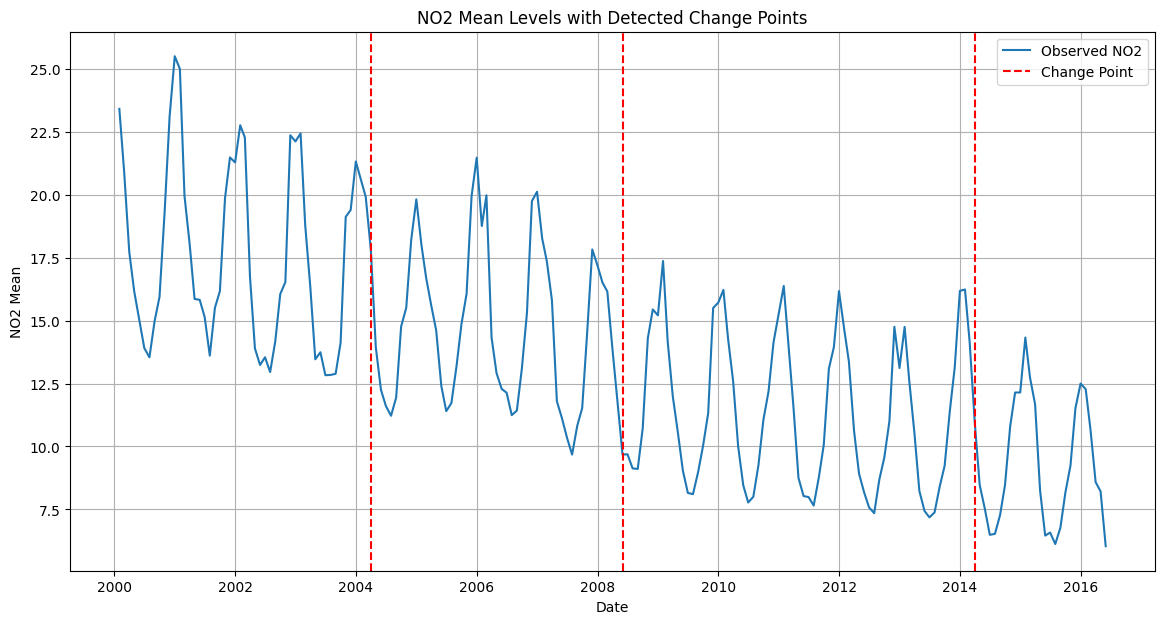

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ruptures import Binseg
from scipy.stats import mannwhitneyu

# Load dataset
df = pd.read_csv("uspollution_pollution_us_2000_2016.csv")
df["Date Local"] = pd.to_datetime(df["Date Local"])
df.set_index("Date Local", inplace=True)

# Aggregate monthly NO2 mean
df_monthly = df.resample("ME")[["NO2 Mean"]].mean().dropna()

# Change-Point Detection using Binseg
algo = Binseg(model="l2").fit(df_monthly["NO2 Mean"].values)
change_points = algo.predict(n_bkps=3)

# Pettitt's Test for change detection significance
for i in range(1, len(change_points)):
    _, p_value = mannwhitneyu(
        df_monthly["NO2 Mean"].iloc[:change_points[i - 1]],
        df_monthly["NO2 Mean"].iloc[change_points[i - 1]:change_points[i]]
    )
    print(f"Pettitt's test between segments {i-1} and {i} - p-value: {p_value:.4f}")

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(df_monthly, label="Observed NO2")
for cp in change_points[:-1]:
    plt.axvline(df_monthly.index[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[1] else '')
plt.title("NO2 Mean Levels with Detected Change Points")
plt.xlabel("Date")
plt.ylabel("NO2 Mean")
plt.legend()
plt.grid(True)
plt.show()

Pettitt's test between segments 0 and 1 - p-value: 0.0001892099925849962
Pettitt's test between segments 1 and 2 - p-value: 1.3508012561873722e-13
Pettitt's test between segments 2 and 3 - p-value: 1.0800008080521081e-08


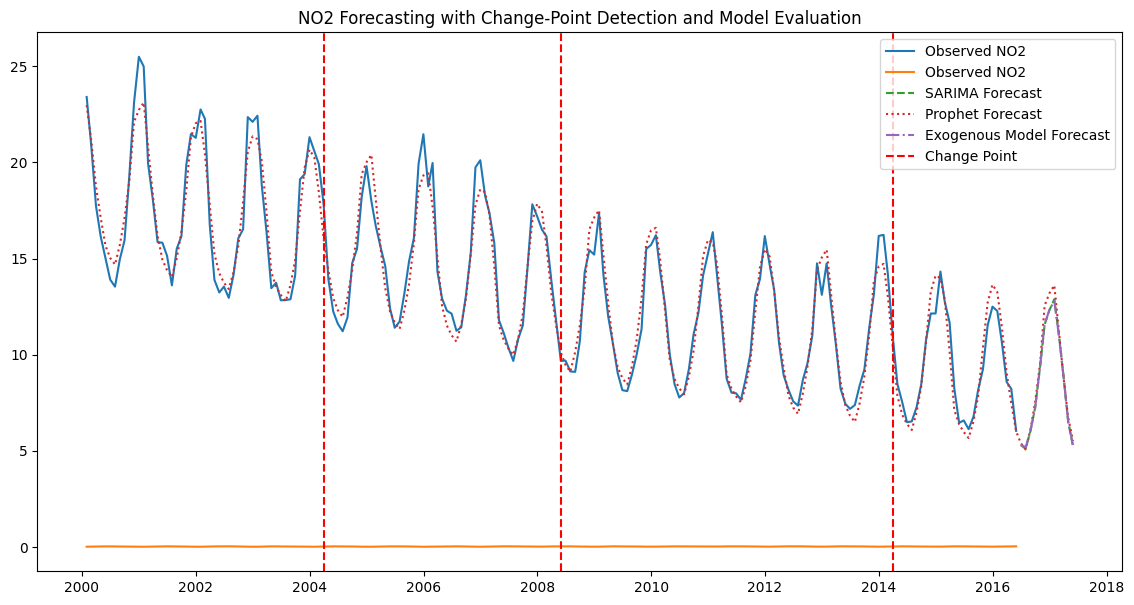

In [40]:

algo = Binseg(model="l2").fit(df_monthly["NO2 Mean"].values)
change_points = algo.predict(n_bkps=3)

# Pettitt's Test
for i in range(1, len(change_points)):
    _, p_value = mannwhitneyu(df_monthly["NO2 Mean"].iloc[:change_points[i-1]],
                              df_monthly["NO2 Mean"].iloc[change_points[i-1]:change_points[i]])
    print(f"Pettitt's test between segments {i-1} and {i} - p-value: {p_value}")

### Visualization
plt.figure(figsize=(14,7))
plt.plot(df_monthly, label="Observed NO2")
plt.plot(forecast_sarima, label="SARIMA Forecast", linestyle="dashed")
plt.plot(forecast_prophet["ds"], forecast_prophet["yhat"], label="Prophet Forecast", linestyle="dotted")
plt.plot(forecast_exog, label="Exogenous Model Forecast", linestyle="dashdot")
for cp in change_points[:-1]:
    plt.axvline(df_monthly.index[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[1] else '')
plt.legend()
plt.title("NO2 Forecasting with Change-Point Detection and Model Evaluation")
plt.show()

Dataset Columns: Index(['Unnamed: 0', 'State Code', 'County Code', 'Site Num', 'Address',
       'State', 'County', 'City', 'Date Local', 'NO2 Units', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'O3 Units',
       'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI',
       'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI'],
      dtype='object')


13:29:10 - cmdstanpy - INFO - Chain [1] start processing
13:29:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\LENOVO\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
c:\Users\LENOVO\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


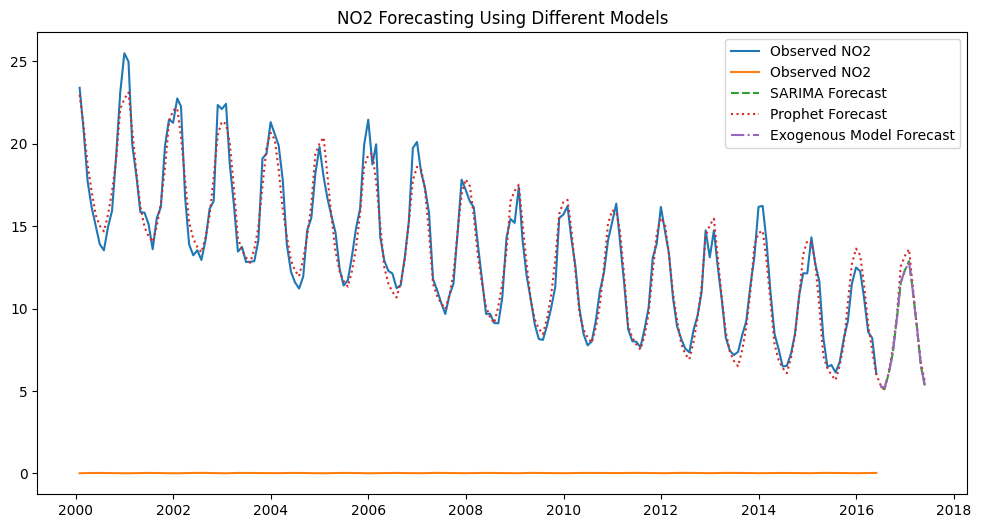

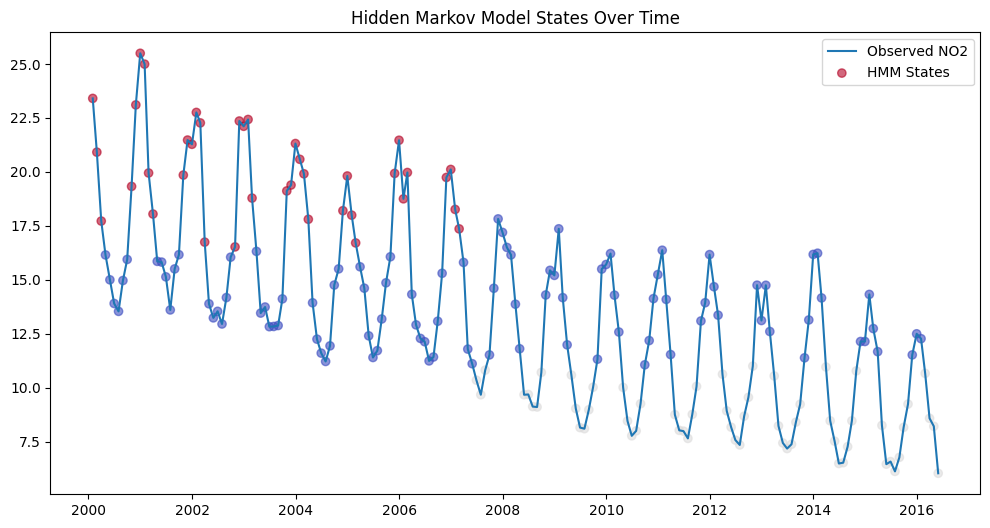

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.stattools import adfuller


# Load dataset
df = pd.read_csv("uspollution_pollution_us_2000_2016.csv")
print("Dataset Columns:", df.columns)  # Debugging step to check column names
df["Date Local"] = pd.to_datetime(df["Date Local"])
df.set_index("Date Local", inplace=True)

# Aggregate NO2 mean monthly
df_monthly = df.resample("ME")[["NO2 Mean"]].mean().dropna()
# Seasonal Decomposition
decomp = seasonal_decompose(df_monthly, model="additive", period=12)

# SARIMA Model
sarima_model = SARIMAX(df_monthly, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
forecast_sarima = sarima_model.get_forecast(steps=12).predicted_mean

# Prophet Model
df_prophet = df_monthly.reset_index().rename(columns={"Date Local": "ds", "NO2 Mean": "y"})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=12, freq="M")
forecast_prophet = prophet_model.predict(future)

# Hidden Markov Model
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_monthly.values.reshape(-1, 1))
hmm_model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
hmm_model.fit(data_scaled)
state_sequence = hmm_model.predict(data_scaled)

# Incorporating Exogenous Variable (O3 levels)
df_monthly["O3"] = df.resample("ME")["O3 Mean"].mean().dropna()
exog_model = SARIMAX(df_monthly["NO2 Mean"], exog=df_monthly["O3"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
forecast_exog = exog_model.get_forecast(steps=12, exog=df_monthly["O3"].iloc[-12:]).predicted_mean

# Fourier Regression for Seasonality
dp = DeterministicProcess(index=df_monthly.index, constant=True, order=1, seasonal=True)
x_reg = dp.in_sample()

# Use only NO2 Mean as the dependent variable (y_reg)
y_reg = df_monthly["NO2 Mean"]

# Fit the SARIMAX model with NO2 Mean as the dependent variable and x_reg as the exogenous variable
reg_model = SARIMAX(y_reg, exog=x_reg, order=(1,1,1)).fit()

# Visualizations
plt.figure(figsize=(12,6))
plt.plot(df_monthly, label="Observed NO2")
plt.plot(forecast_sarima, label="SARIMA Forecast", linestyle="dashed")
plt.plot(forecast_prophet["ds"], forecast_prophet["yhat"], label="Prophet Forecast", linestyle="dotted")
plt.plot(forecast_exog, label="Exogenous Model Forecast", linestyle="dashdot")
plt.legend()
plt.title("NO2 Forecasting Using Different Models")
plt.show()


# HMM State Visualization
plt.figure(figsize=(12,6))

# Plot the observed NO2 levels
plt.plot(df_monthly.index, df_monthly["NO2 Mean"], label="Observed NO2")

# Scatter plot of HMM states
plt.scatter(df_monthly.index, df_monthly["NO2 Mean"], c=state_sequence, cmap="coolwarm", label="HMM States", alpha=0.6)

plt.legend()
plt.title("Hidden Markov Model States Over Time")
plt.show()